# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [24]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures

## Read data 

In [25]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Descriptive plots

<Axes: xlabel='lgdp_initial', ylabel='gdp_growth'>

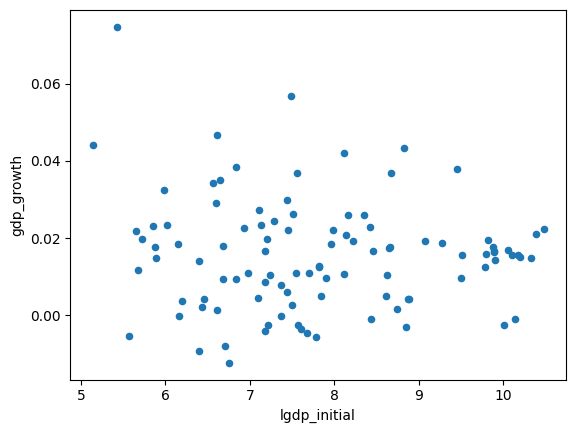

In [26]:
dat.plot.scatter(x='lgdp_initial', y='gdp_growth')

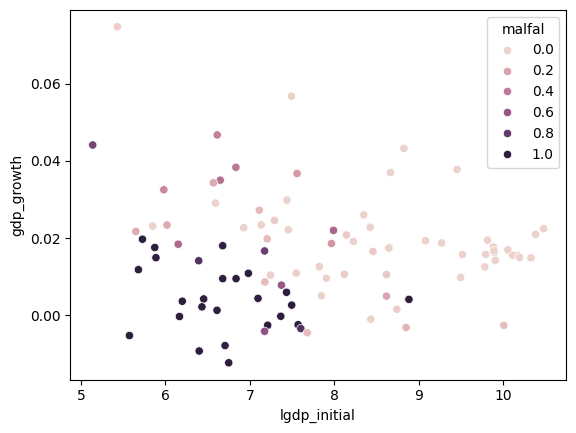

In [27]:
import seaborn as sns 
sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='malfal');

# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [28]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]


In [29]:
# convenient to keep a column of ones in the dataset
dat['constant'] = np.ones((dat.shape[0],))
print(dat)

    code  marketref  dem  demCGV  demBMR    demreg      lp_bl      ls_bl  \
0    AFG        NaN  0.0     0.0     0.0  0.000000   4.109822   0.564805   
1    AGO        NaN  NaN     NaN     NaN  0.031250        NaN        NaN   
2    ALB   9.090906  0.0     0.0     0.0  0.037037  32.111988  32.864277   
3    ARE        NaN  NaN     NaN     NaN       NaN        NaN        NaN   
4    ARG  34.144062  0.0     0.0     0.0  0.071429  72.400000  15.300000   
..   ...        ...  ...     ...     ...       ...        ...        ...   
209  PYF        NaN  NaN     NaN     NaN       NaN        NaN        NaN   
210  SMR        NaN  NaN     NaN     NaN       NaN        NaN        NaN   
211  TMP        NaN  NaN     NaN     NaN       NaN        NaN        NaN   
212  VIR        NaN  NaN     NaN     NaN       NaN        NaN        NaN   
213  WBG        NaN  NaN     NaN     NaN       NaN        NaN        NaN   

        lh_bl  tropicar  ...  capital_growth_pct_gdp_initial  \
0    1.096088  0.000000

# Simple OLS

In [30]:
# 1. avoiding missings 
I = dat[['gdp_growth', 'lgdp_initial']].notnull().all(axis=1)

# 2. extract dataset 
y = dat.loc[I, 'gdp_growth'].values.reshape((-1,1)) * 100.0
X = dat.loc[I, ['constant','lgdp_initial']].values

# 3. run OLS
betahat = np.linalg.inv(X.T @ X) @ X.T @ y
print(betahat)

[[ 2.24792211]
 [-0.08713416]]


# Adding more controls

In [41]:
vs = vv_all['geography'] + vv_all['religion'] + vv_all['resources'] + vv_educ
xs = ['lgdp_initial', 'pop_growth', 'investment_rate'] + vs

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
X = dat.loc[I, xs].values
print(X.shape)
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%

# add const. (unless this breaks the rank condition)
oo = np.ones((I.sum(),1))
X = np.hstack([X, oo])

xs.append('constant') # we put it in as the last element

# check the rank condition
K = X.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

# compute the OLS estimator
betas = np.linalg.inv(X.T @ X) @ X.T @ y

(81, 34)


In [32]:
# format nicely
print(f'Mean y = {y.mean(): 5.2f}% growth per year')
pd.DataFrame({'β': betas[:,0]}, index=xs).round(3)

Mean y =  1.52% growth per year


,β
lgdp_initial,-1.118
pop_growth,6.830
investment_rate,0.068
tropicar,-0.411
distr,-0.000
distcr,0.001
distc,-0.003
suitavg,-1.063
temp,-0.204
suitgini,-0.771


# User generated code

4      ARG
7      AUS
8      AUT
10     BDI
11     BEL
      ... 
175    URY
176    USA
185    ZAF
187    ZMB
188    ZWE
Name: code, Length: 81, dtype: object


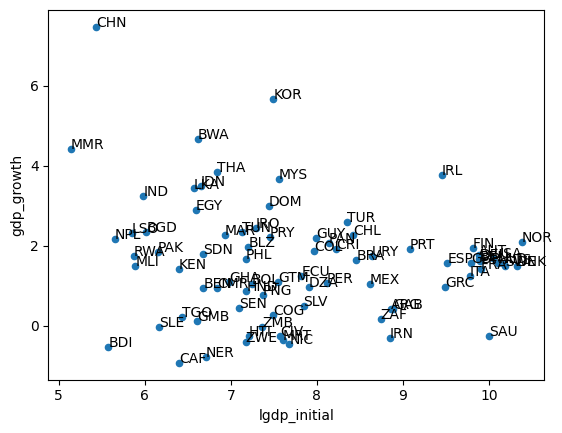

In [45]:
# Quick check: selected data are the actual countries when visualizing by country code.
country_code = dat.loc[I, 'code'] # country code for I criterion.
#print(country_code.shape[0] == X.shape[0]) # dimension check

data_selected = pd.DataFrame(X, columns=xs, index=country_code)
print(country_code)
y_df = pd.DataFrame(y, columns=['gdp_growth'], index=country_code)
data_final = pd.concat([y_df, data_selected], axis=1)
#print(data_final.head())


ax_data = data_final.plot.scatter(x='lgdp_initial', y='gdp_growth')
for idx, row in data_final.iterrows():
    ax_data.annotate(idx, (row['lgdp_initial'], row['gdp_growth']))

# Lasso

In [34]:
for key in vv_all.keys():
    print(f'Number of variables in {key}: {len(vv_all[key])}')
    print(f'The variables are: {", ".join(vv_all[key])}')
    # print(f'Missing values in {key}: {dat[vv_all[key]].isnull().sum()}')


Number of variables in institutions: 5
The variables are: marketref, dem, demCGV, demBMR, demreg
Number of variables in geography: 21
The variables are: tropicar, distr, distcr, distc, suitavg, temp, suitgini, elevavg, elevstd, kgatr, precip, area, abslat, cenlong, area_ar, rough, landlock, africa, asia, oceania, americas
Number of variables in geneticdiversity: 4
The variables are: pdiv, pdiv_aa, pdivhmi, pdivhmi_aa
Number of variables in historical: 5
The variables are: pd1000, pd1500, pop1000, pop1500, ln_yst
Number of variables in religion: 3
The variables are: pprotest, pcatholic, pmuslim
Number of variables in danger: 3
The variables are: yellow, malfal, uvdamage
Number of variables in resources: 5
The variables are: oilres, goldm, iron, silv, zinc
Number of variables in all: 46
The variables are: marketref, dem, demCGV, demBMR, demreg, tropicar, distr, distcr, distc, suitavg, temp, suitgini, elevavg, elevstd, kgatr, precip, area, abslat, cenlong, area_ar, rough, landlock, africa

In [35]:
I = dat[['gdp_growth', 'lgdp_initial'] + vv_all["all"]].notnull().all(axis=1)
x = dat.loc[I, vv_all["geography"]]
print(x.shape)
print(I.shape)

(63, 21)
(214,)


In [36]:
# check missing values of the z numpy array 
missing_values = np.isnan(y).sum()
print("Missing values in z array:", missing_values)


Missing values in z array: 0


In [ ]:
# Make a function that calculates BRT. Hint: You implemented a version of this last week
def BRT(X_tilde, y, c=1.1, alpha=0.05):
    (N,p) = X_tilde.shape
    sigma = np.std(y, ddof=1)
    penalty_BRT= (sigma*c)/np.sqrt(N)*norm.ppf(1-alpha/(2*p))
    return penalty_BRT

penalty_BRTyx = BRT(X,y)
print("lambda_BRT =",penalty_BRTyx.round(2))

In [ ]:
fit_BRTyx = Lasso(alpha=penalty_BRTyx).fit(X, y)
coefs = fit_BRTyx.coef_
Z_J = X[:, coefs[0:]!=0] # Extract coeffs diff from zero. 
print("The number of variables in Z_J is {}".format(Z_J.shape[1]))

In [ ]:
def plot_lasso_path(penalty_grid, coefs, legends, vlines: dict = None):
    """
    Plots the coefficients as a function of the penalty parameter for Lasso regression.

    Parameters:
    penalty_grid (array-like): The penalty parameter values.
    coefs (array-like): The estimated coefficients for each penalty value.
    legends (list): The labels for each coefficient estimate.
    vlines (dict, optional): A dictionary of vertical lines to add to the plot. The keys are the names of the lines and the values are the penalty values where the lines should be drawn.
    
    """
    # Initiate figure 
    fig, ax = plt.subplots()

    # Plot coefficients as a function of the penalty parameter
    ax.plot(penalty_grid, coefs)

    # Set log scale for the x-axis
    ax.set_xscale('log')

    # Add labels
    plt.xlabel('Penalty, $\lambda$')
    plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
    plt.title('Lasso Path')

    # Add legends
    lgd=ax.legend(legends,loc=(1.04,0))
    
    # Add vertical lines
    if vlines is not None:
        for name, penalty in vlines.items():
            ax.axvline(x=penalty, linestyle='--', color='grey')
            plt.text(penalty,-80000,name,rotation=90)

    # Display plot
    plt.show()
    plt.close()


In [ ]:
# Create a grid using numpy.geomspace
penalty_grid = np.geomspace(0.01, 80000, num = 28)
Xnames = x.columns
print(y.shape)
print(X.shape)
print(coefs.shape)
print(penalty_grid.shape)
print(Xnames.shape)

In [ ]:
plot_lasso_path(penalty_grid, coefs, Xnames)